## Spell Decoder - Setup and Simulations


In [89]:
import numpy as np
import scipy
from sklearn import datasets
import matplotlib.pyplot as plt

## Assumptions (simplest case)
Let $C \in \mathbb N$ be the number of `channels` and $T \in \mathbb N$ be the number of sampled `time points` and $\mathcal S$ be the set of `spells`.

We assume that a single trial $X$ has the following properties:
- Weakly stationary stochastic process: $X = (X_t)_{t = 1, \ldots,  T}$ with $X_t \in \mathbb R^{C}$ and $\mathbb E[X_t | s] = a_s$ (regardless of $t$)
- Stable VAR(1) structure: $X_t|s = a_s + \mathbf A_s X_{t-1} + U_t$ with $\,\mathbb E[U_t] = 0, \; \mathbb E[U_tU_t^\top] = \boldsymbol \Sigma, \; \underset{k \neq t}{\forall} \; \mathbb E[U_tU_k^\top] = \mathbf 0$, and all eigenvalues of $A_s$ have modulus less than 1.

Then there exists a maximum likelihood estimator for $ B_s = (a_s, \mathbf A_s)$ with $\mathbf{Z = (Z_0, \ldots, Z_{T-1})}, \; \mathbf{Z_t = (1, X_t)^\top}$: $\hat B_s = \mathbf{XZ^\top(ZZ^\top)^{-1}}$.

### 0. The Data

In [90]:
nChan = 102 # number of magnetometer channels
nObs = 30 
nSeconds = 5
Hz = 20
nSamples = nSeconds * Hz # 5 seconds of data at 20 Hz
nSpells = 3

In [91]:
def plotMat(matrix: np.ndarray, title: str) -> None:
    fig, ax = plt.subplots()
    plt.imshow(matrix, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    ax.xaxis.tick_top()

def genPDMat(n: int) -> np.ndarray:
    A = np.random.randint(10, size=(n, n))
    _, eigenvectors = np.linalg.eig(A)
    eigenvalues = np.random.uniform(low=-1., high=1., size=n)
    pdmat = eigenvectors @ np.diag(eigenvalues) @ np.linalg.inv(eigenvectors)
    return np.real(pdmat)

var = 0.5
sigma = datasets.make_spd_matrix(nChan) + var * np.eye(nChan)
mus = [np.random.randint(low=-10, high=10, size=nChan) for _ in range(nSpells)]
As = [genPDMat(nChan) for _ in range(nSpells)]


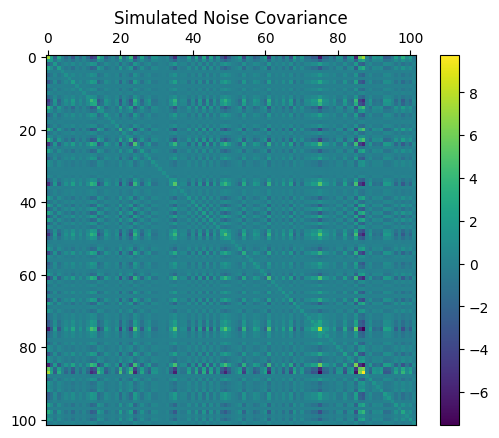

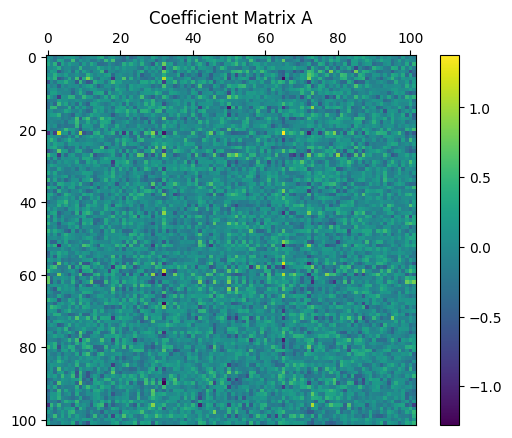

In [92]:
plotMat(sigma, "Simulated Noise Covariance")
plotMat(As[0], "Coefficient Matrix A")

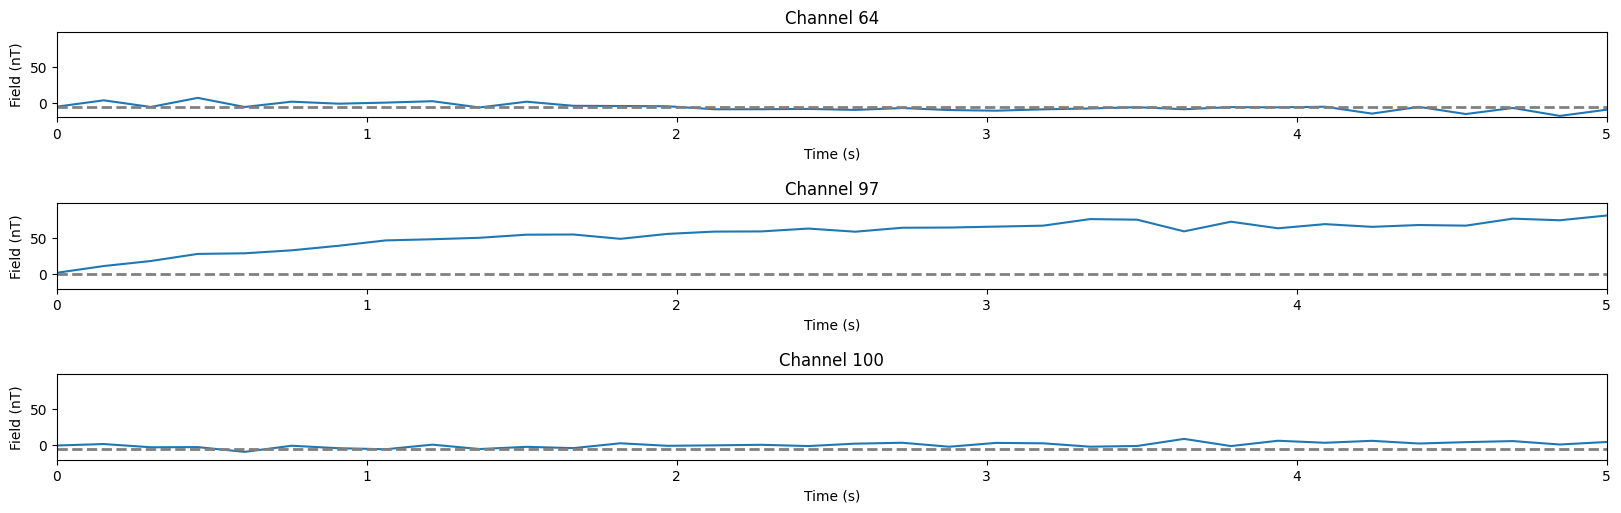

In [93]:
def genVAR(nChan: int, nSamples: int, mu: np.ndarray, sigma: np.ndarray, A: np.ndarray) -> np.ndarray:
    x = np.zeros((nChan, nSamples)) + mu[:, np.newaxis]
    noise = np.random.multivariate_normal(np.zeros(nChan), sigma, size=nSamples).T
    x[:,0] += noise[:,0]
    for t in range(1, nSamples):
        x[:,t] += A @ x[:,t-1] + noise[:,t] 
    return x

def plotSomeChannels(x: np.ndarray, nPlots:int, nChan: int, nSamples: int) -> None:
    channels = sorted(np.random.choice(nChan, size=nPlots, replace=False))
    plt.figure(figsize=(20,10))
    t = np.linspace(0, 15, nSamples)

    for i, c in enumerate(channels):
        plt.subplot(5, 1, i+1)
        plt.plot(t, x[c,:])
        plt.title(f"Channel {c}")
        plt.xlabel("Time (s)")
        plt.ylabel("Field (nT)")   
        plt.xlim([0, nSeconds])
        plt.ylim([np.min(x[channels,:]), np.max(x[channels,:])])
        plt.plot([0, nSamples], [mu[c], mu[c]], color='grey', linestyle='--', linewidth=2)
        plt.subplots_adjust(hspace=1.)

x = genVAR(nChan, nSamples, mus[0], sigma, As[0])
plotSomeChannels(x, 3, nChan, nSamples)

Let us now generate data and check if we build a multinomial classifier based on them:

In [94]:
from sklearn.model_selection import train_test_split
X = np.array([genVAR(nChan, nSamples, mus[i], sigma, As[i]) for _ in range(nObs) for i in range(nSpells)]) # shape (nObs * nSpells, nChan, nSamples)
X_train, X_test, y_train, y_test = train_test_split(X, [0] * nObs + [1] * nObs + [2] * nObs, test_size=0.2, random_state=42)

In [95]:
from sklearn.linear_model import LogisticRegression    
mnc = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=1000, penalty="l2")

def getAccuracy(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, mnc: LogisticRegression) -> float:
    trainAcc = []
    testAcc = []
    for i in range(nSamples):
        print(f"Training on time point {i+1} of {nSamples}")
        mnc = mnc.fit(X_train[:,:,i], y_train)
        trainAcc.append(mnc.score(X_train[:,:,i], y_train))
        testAcc.append(mnc.score(X_test[:,:,i], y_test))
    return trainAcc, testAcc

trainAcc, testAcc = getAccuracy(X_train, y_train, X_test, y_test, mnc)


Training on time point 1 of 100
Training on time point 2 of 100
Training on time point 3 of 100
Training on time point 4 of 100
Training on time point 5 of 100
Training on time point 6 of 100
Training on time point 7 of 100
Training on time point 8 of 100
Training on time point 9 of 100
Training on time point 10 of 100
Training on time point 11 of 100
Training on time point 12 of 100
Training on time point 13 of 100
Training on time point 14 of 100
Training on time point 15 of 100
Training on time point 16 of 100
Training on time point 17 of 100
Training on time point 18 of 100
Training on time point 19 of 100
Training on time point 20 of 100
Training on time point 21 of 100
Training on time point 22 of 100
Training on time point 23 of 100
Training on time point 24 of 100
Training on time point 25 of 100
Training on time point 26 of 100
Training on time point 27 of 100
Training on time point 28 of 100
Training on time point 29 of 100
Training on time point 30 of 100
Training on time po

/kyb/rg/akipnis/anaconda3/envs/pml/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/kyb/rg/akipnis/anaconda3/envs/pml/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Training on time point 53 of 100
Training on time point 54 of 100
Training on time point 55 of 100
Training on time point 56 of 100
Training on time point 57 of 100
Training on time point 58 of 100
Training on time point 59 of 100
Training on time point 60 of 100
Training on time point 61 of 100
Training on time point 62 of 100
Training on time point 63 of 100
Training on time point 64 of 100
Training on time point 65 of 100
Training on time point 66 of 100
Training on time point 67 of 100
Training on time point 68 of 100
Training on time point 69 of 100


/kyb/rg/akipnis/anaconda3/envs/pml/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/kyb/rg/akipnis/anaconda3/envs/pml/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Training on time point 70 of 100
Training on time point 71 of 100
Training on time point 72 of 100
Training on time point 73 of 100
Training on time point 74 of 100
Training on time point 75 of 100


/kyb/rg/akipnis/anaconda3/envs/pml/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/kyb/rg/akipnis/anaconda3/envs/pml/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Training on time point 76 of 100
Training on time point 77 of 100
Training on time point 78 of 100
Training on time point 79 of 100
Training on time point 80 of 100
Training on time point 81 of 100
Training on time point 82 of 100
Training on time point 83 of 100
Training on time point 84 of 100
Training on time point 85 of 100
Training on time point 86 of 100
Training on time point 87 of 100
Training on time point 88 of 100
Training on time point 89 of 100
Training on time point 90 of 100
Training on time point 91 of 100
Training on time point 92 of 100
Training on time point 93 of 100
Training on time point 94 of 100
Training on time point 95 of 100
Training on time point 96 of 100
Training on time point 97 of 100
Training on time point 98 of 100
Training on time point 99 of 100
Training on time point 100 of 100


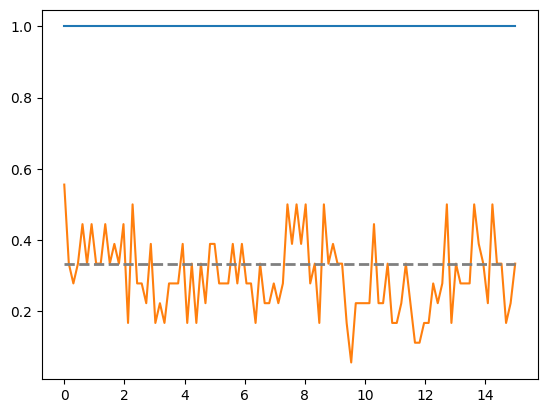

In [96]:
plt.plot(np.linspace(0, 15, nSamples), trainAcc)
plt.plot(np.linspace(0, 15, nSamples), testAcc)
plt.plot([0, 15], [1/nSpells, 1/nSpells], color='grey', linestyle='--', linewidth=2)
